

# Introduction to Natural Language Processing

&nbsp;
&nbsp;
&nbsp;

**Miguel Zabaleta Sarasa (100463947)**

# Clasifying documents using topic models

In this homework, we are using the [20Newsgroup](http://qwone.com/~jason/20Newsgroups/) datasets. It contains 20,000 documents with messages sent to different distribution lists. The dataset is available through Sklearn:

In [1]:
from sklearn.datasets import fetch_20newsgroups
newsgroups = fetch_20newsgroups(subset='all', shuffle = True, remove=('headers', 'footers', 'quotes'))

We can access the documents as follows

In [2]:
print(type(newsgroups.data))

print('There are %d documents' %(len(newsgroups.data)))

<class 'list'>
There are 18846 documents


In [3]:
print(newsgroups.data[50])



WHen trying to choose a resistor with a tolerance better than 1%, you 
need a trimmer or to screen devices, it can't be made from adding 2 
resitors of 1% value in parallel, since the smaller device will have the 
error of 1% to cope with. 
You have 3 choices;
a) live with the error of 1% tolerance devices for low Q circuits or low 
sensitivity designs
b) buy resistors with better than 1% tolerance (Vishay/Dale)
c) use trimmers or SOT's (Select-On-Test)


The documents are classified in 20 grops:

In [4]:
newsgroups.target

array([10,  3, 17, ...,  3,  1,  7])

In [5]:
import pandas as pd

df = pd.DataFrame({'Category':newsgroups.target_names,'Label':range(len(newsgroups.target_names))})

df

,Category,Label
0,alt.atheism,0
1,comp.graphics,1
2,comp.os.ms-windows.misc,2
3,comp.sys.ibm.pc.hardware,3
4,comp.sys.mac.hardware,4
5,comp.windows.x,5
6,misc.forsale,6
7,rec.autos,7
8,rec.motorcycles,8
9,rec.sport.baseball,9


In this notebook we will analyze the corpus from a topic modelling point of view and classify the documents:

1) Merge labels according to the following table

<img src='http://www.tsc.uc3m.es/~olmos/BBVA/categories_20_News.png' width=400 />

2) Split in train (70%), validation (10%) and test (20%). Define the diccionary using gensim and filter too-frequent tokens. Construct the BoW representation of the model

3) Build an LDA model for on the training set. To validate the number of topics, study the consistency of the topics in the validation set. For the selected number of topics, study their interpretability by analyzing the most likely words per topic.

4) Train a logistic regression  classifier to classify each document using its LDA representation. Represent the confusion matrix in test and determine which categories are more problematic. Repeat for a k-NN classifier. Discuss the results.

5) Compare the results with a classifier that uses the TF-IDF representation. Discuss the results.



## 1.

In [6]:
# 1. 
lst = [[1,2,3,4,5],[7,8,9,10],[11,12,13,14],[6],[16,17,18],[0,15,19]]
for j in range(6):
  for k in lst[j]:
    newsgroups.target[newsgroups.target==k] = j

newsgroups.target

array([1, 5, 4, ..., 5, 5, 1])

## 2.

In [7]:
# 2. 
# train 70%
# validation 10%
# test 20%
import numpy as np
N = len(newsgroups.data)
n_train = int(np.ceil(N*0.7))
n_val = int(np.ceil(N*0.1))
n_test = int(np.ceil(N*0.2))

train_text = newsgroups.data[0:n_train-1]
val_text = newsgroups.data[n_train:n_train+n_val-2]
test_text = newsgroups.data[n_train+n_val-1:n_train+n_val+n_test-3]

In [8]:
# !pip install --upgrade spacy

# Download the model
!python -m spacy download en_core_web_sm

import spacy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.0 MB 8.1 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [9]:
# We load the model
nlp = spacy.load("en_core_web_sm")

def normalize_Spacy(text):
    text2 = nlp(text)
    normalized_text = [w.lemma_.lower() for w in text2 if not w.is_stop 
                  and not w.is_punct and (w.is_alpha or w.is_digit)]
    return normalized_text


train_token = []
for doc in train_text:
  train_token.append(normalize_Spacy(doc))

val_token = []
for doc in val_text:
  val_token.append(normalize_Spacy(doc))

test_token = []
for doc in test_text:
  test_token.append(normalize_Spacy(doc))

In [13]:
import gensim

D_train = gensim.corpora.Dictionary(train_token)
D_test = gensim.corpora.Dictionary(test_token)

no_below = 5 # Minimum number of documents to keep a term in the dictionary
no_above = .75 # Maximum proportion of documents in which a term can appear to be kept in the dictionary

# we will remove too frequent tokens, and put no limit as to the number of tokens we will keep
D_train.filter_extremes(no_below=no_below,no_above=no_above)
D_test.filter_extremes(no_below=no_below,no_above=no_above)

In [14]:
train_bow = [D_train.doc2bow(doc) for doc in train_token]
val_bow = [D_train.doc2bow(doc) for doc in val_token]
test_bow = [D_test.doc2bow(doc) for doc in test_token]

## 3.

Since we will try to predict the categories of labels later on, and there are 6 categories, the number of variables (i.e. the number of topics) need to be at least 5, since it's not possible to discriminate between 6 labels otherwise.

Therefore, we will start the analysis of the consistency of labels beginning with 5 topics and compare until 10 topics.

In [15]:
from gensim.models.coherencemodel import CoherenceModel

K_max = 11

L_UCI = []

L_mass = []

L_NPMI = []

L_perp = []

L_UCI_train = []

L_mass_train = []

L_NPMI_train = []

L_perp_train = []

topic_models = {}


for k in range(5,K_max,1):
    
    print(k)
    
    topic_models[k] = gensim.models.LdaMulticore(train_bow, num_topics=k, id2word = D_train, passes=30) # Utilizamos BOW en lugar de TF-IDF!
    
    #### Perplexity
    
    L_perp.append(topic_models[k].log_perplexity(val_bow))
    
    L_perp_train.append(topic_models[k].log_perplexity(train_bow))
    
    #### UCI
    
    cm = CoherenceModel(model=topic_models[k], texts=val_token, dictionary=D_train, coherence='c_uci')
    
    L_UCI.append(cm.get_coherence())
    
    cm = CoherenceModel(model=topic_models[k], texts=train_token, dictionary=D_train, coherence='c_uci')
    
    L_UCI_train.append(cm.get_coherence())    
    
    #### UMASS
    
    cm = CoherenceModel(model=topic_models[k], texts=val_token, dictionary=D_train, coherence='u_mass')
    
    L_mass.append(cm.get_coherence())
    
    cm = CoherenceModel(model=topic_models[k], texts=train_token, dictionary=D_train, coherence='u_mass')
    
    L_mass_train.append(cm.get_coherence())
    
    #### CNPMI   
    
    cm = CoherenceModel(model=topic_models[k], texts=val_token, dictionary=D_train, coherence='c_npmi')
    
    L_NPMI.append(cm.get_coherence())
    
    cm = CoherenceModel(model=topic_models[k], texts=train_token, dictionary=D_train, coherence='c_npmi')
    
    L_NPMI_train.append(cm.get_coherence())

5
6
7
8
9
10


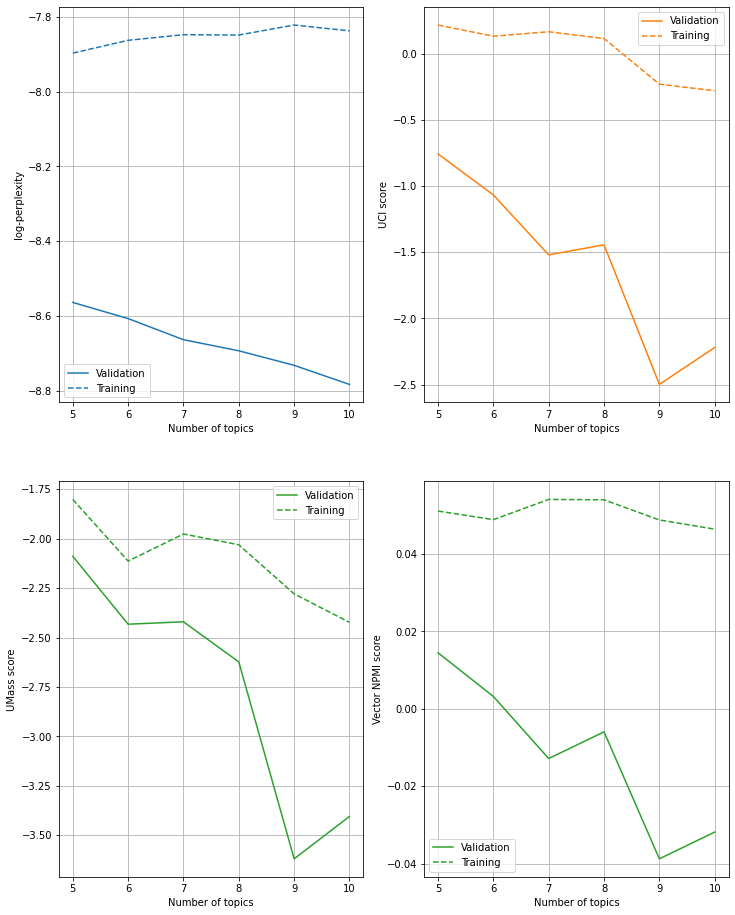

In [18]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

fig, axes = plt.subplots(2, 2, figsize=(12,16))
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

axes[0,0].plot(range(5,K_max,1),L_perp,color=cols[0],label='Validation')
axes[0,0].plot(range(5,K_max,1),L_perp_train,'--',color=cols[0],label='Training')
axes[0,0].set_ylabel('log-perplexity')
axes[0,0].set_xlabel('Number of topics')
axes[0,0].legend()
axes[0,0].grid()

axes[0,1].plot(range(5,K_max,1),L_UCI,color=cols[1],label='Validation')
axes[0,1].plot(range(5,K_max,1),L_UCI_train,'--',color=cols[1],label='Training')
axes[0,1].set_ylabel('UCI score')
axes[0,1].set_xlabel('Number of topics')
axes[0,1].legend()
axes[0,1].grid()

axes[1,0].plot(range(5,K_max,1),L_mass,color=cols[2],label='Validation')
axes[1,0].plot(range(5,K_max,1),L_mass_train,'--',color=cols[2],label='Training')
axes[1,0].set_ylabel('UMass score')
axes[1,0].set_xlabel('Number of topics')
axes[1,0].legend()
axes[1,0].grid()

axes[1,1].plot(range(5,K_max,1),L_NPMI,color=cols[2],label='Validation')
axes[1,1].plot(range(5,K_max,1),L_NPMI_train,'--',color=cols[2],label='Training')
axes[1,1].set_ylabel('Vector NPMI score')
axes[1,1].set_xlabel('Number of topics')
axes[1,1].legend()
axes[1,1].grid()


Observing the results (min LP, max UCI, max UMass, min NMPI), 7 or 8 topics seems like a good option either way.  
We will finally select **7 topics**. 

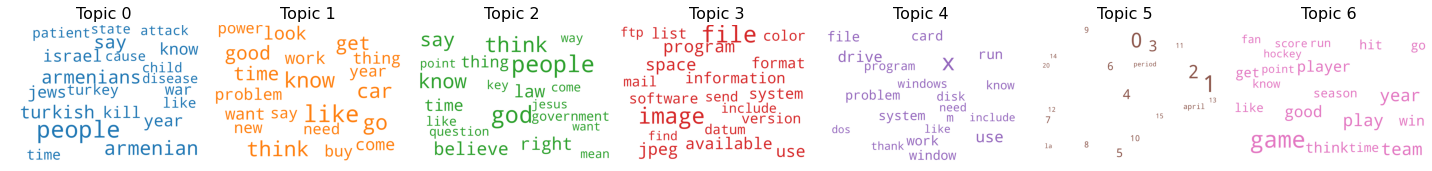

In [23]:
from wordcloud import WordCloud, STOPWORDS


lda = gensim.models.LdaMulticore(train_bow, num_topics=7, id2word = D_train, passes=10)

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(background_color='white',
                  width=2500,
                  height=1800,
                  max_words=20,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda.show_topics(formatted=False,num_words=20)

fig, axes = plt.subplots(1, 7, figsize=(20,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

What I have done in order to compare these topics in a somewhat organized way is to determine which are the clear topics I interpret they have been able to substact.

I have interpreted these topics with the merged categories in mind (computer science, autos+motos+sports, science, misc, politics, religion).

Something I have observed is that many of the obtained topics that are a mix or unclear interpretation is because they have a lot of **verbs**.

Verbs seem like words that could be present in many of these topics.  
Therefore, if a wordcloud has many verbs in them, I will consider it as misc, with a particular specialization if needed (for instance, misc (religion)).

Taking this into account, these are the interpretations I have found for the given topics:

<br>

- Politics, misc, religion, CS, CS, numbers, sports



## 4.

In [ ]:
# 4.
from gensim.matutils import corpus2dense

lda_model = gensim.models.LdaMulticore(train_bow, num_topics=7, id2word = D_train, passes=10)
topics_train = lda_model[train_bow]
X_train = corpus2dense(topics_train, num_terms=7, num_docs=len(topics_train)).T

topics_test = lda_model[test_bow]
X_test = corpus2dense(topics_test, num_terms=7, num_docs=len(topics_test)).T

Y_train = newsgroups.target[0:n_train-1]
Y_test = newsgroups.target[n_train+n_val:]

print(X_train.shape)
print(Y_train.shape)

print(X_test.shape)
print(Y_test.shape)

(13192, 7)
(13192,)
(3768, 7)
(3768,)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

mod = LogisticRegression(random_state=100463947,max_iter=10000).fit(X_train,Y_train)
pred = mod.predict(X_test)
print(confusion_matrix(Y_test, pred))

[[326 109   0  51 326]
 [331 105   1  33 318]
 [ 80  24   0  11  90]
 [227  72   1  32 196]
 [593 187   1  89 565]]


The two most problematic categories are the third and fourth ones, which correspond to **science** and **misc**.

This makes a lot of sense and is related to what we mentioned when discussing the interpretation of the topics: that there were many **topics with verbs** in them, which makes it difficult to clearly interpret them, as verbs are words which can be present in many different topics. 

Additionally, **science** is a topic where by its nature, the worlds in those documents could be assigned to many other topics, like politics, misc, CS,... 

The same can be said for the **misc** topic.

Finally, the science and misc topics where the hardest to clearly interpret in the word cloud, as they had verbs in them in many occasions.

All of this makes them the hardest categories to predict, which is precisely what happened.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

mod = KNeighborsClassifier().fit(X_train,Y_train)
pred = mod.predict(X_test)
print(confusion_matrix(Y_test, pred))

[[310 229  31 106 136]
 [336 211  33  88 120]
 [ 72  64   7  24  38]
 [204 163  25  73  63]
 [570 400  69 173 223]]


Using KNN as the classifier, the hardest categories still remain being science and misc.

However, this time the results seem to have improved for the second, third and forth category.  
On the other hand, they have worsen for the first category, and for the fifth, the predictions are much worse than in the first model.

Overall, the first model achieved 1028 correctly predicted observations, while the second obtained 824, which is a **19.8% decrease in performance**.

## 5.

In [ ]:
# 5.
from gensim.models import TfidfModel

model = TfidfModel(train_bow)  
tfidf_train = model[train_bow]
tfidf_test = model[test_bow]

from gensim.matutils import corpus2dense

lda_model = gensim.models.LdaMulticore(tfidf_train, num_topics=7, id2word = D_train, passes=10)
topics_train = lda_model[tfidf_train]
X_train = corpus2dense(topics_train, num_terms=7, num_docs=len(topics_train)).T

topics_test = lda_model[tfidf_test]
X_test = corpus2dense(topics_test, num_terms=7, num_docs=len(topics_test)).T

Y_train = newsgroups.target[0:n_train-1]
Y_test = newsgroups.target[n_train+n_val:]

mod = LogisticRegression(random_state=100463947,max_iter=10000).fit(X_train,Y_train)
pred = mod.predict(X_test)
print(confusion_matrix(Y_test, pred))

[[235 126   0  38 413]
 [250 134   0  32 372]
 [ 58  37   0   7 103]
 [169  85   0  20 254]
 [475 207   0  69 684]]


This time, the worst categories remain the same, but we have been able to increase the performance a bit, with a total of 1073 correct predictions (as opposed to the previous 1028).

Looking into the correct predictions for each categoy, we have that this new model improves the predictions in the second, fourth and fifth categories, while it performs worse on the others (compared to the other LR model).

The improvements made by using the TF-IFD representation speak to the fact that this representation tries to adjust the frequency of the words by rewarding more domain-specific words.

This would hopefully make the topics more domain-specific, with less ambiguous words, and ultimately better category predictions.